In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers, layers
from tensorflow.keras.models import load_model 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from functools import partial, reduce

In [3]:
# read dataframe
clev = pd.read_csv('processed.cleveland.data')

In [4]:
# replace '?' with nan, then drop the entry
def remove_invalid_entries(d):
    d = d.replace('?', np.nan)
    d = d.dropna(axis=0)
    return d

In [5]:
# fix dataframe
df = remove_invalid_entries(clev)

In [6]:
#check dtypes
print(df.dtypes)

63.0     float64
1.0      float64
1.0.1    float64
145.0    float64
233.0    float64
1.0.2    float64
2.0      float64
150.0    float64
0.0      float64
2.3      float64
3.0      float64
0.0.1     object
6.0       object
0          int64
dtype: object


In [7]:
# dtype object cannot be processed by the following function, it needs to be transformed into numbers
list11 = []
list12 = []

[list11.append(float(i)) for i in df.iloc[:,11]]
[list12.append(float(i)) for i in df.iloc[:,12]]

df.iloc[:,11] = list11
df.iloc[:,12] = list12

In [8]:
# re-check dtypes
print(df.dtypes)

63.0     float64
1.0      float64
1.0.1    float64
145.0    float64
233.0    float64
1.0.2    float64
2.0      float64
150.0    float64
0.0      float64
2.3      float64
3.0      float64
0.0.1    float64
6.0      float64
0          int64
dtype: object


In [9]:
# convert dataframe into numpy array
df_numpy = df.to_numpy()

In [10]:
# define F-test
def f_test(x, y, feature_names, p_cutoff = 0.05):

    num_features = len(feature_names)
    raw_scores, p_values = f_regression(x, y)
    scores = np.zeros(num_features)

    # keep non-statistically significant scores at 0
    for i in range(num_features):
        if (p_values[i] < p_cutoff):
            scores[i] = raw_scores[i]

    return zip(*sorted(zip(scores, feature_names)))

In [11]:
# split dataset for training, validation and testing
X_train, X_test, Y_train, Y_test = train_test_split(df_numpy[:,:-1], df_numpy[:,-1], test_size=0.2)

In [12]:
# show less significant features at the beginning, more significant at the end
feature_names = ['age', 'gender', 'chest_pain', 'rest_blood_pressure', 'serum_col', 'blood_sugar', 'rest_electrocard',
               'max_heart_rate', 'exercise_angina', 'exercise_depression', 'exercise_slope', 'num_major_vessels', 'thal']
scores, features_names_sort = f_test(X_train, Y_train, feature_names)

print(scores, features_names_sort)

(0.0, 0.0, 6.962302753330009, 7.087608088316856, 11.85307627118644, 12.526557984515504, 37.48316726681815, 39.69694145997216, 46.70898372006046, 52.322985009989125, 77.89972758725895, 79.61593831526856, 97.67534124488277) ('blood_sugar', 'serum_col', 'rest_electrocard', 'rest_blood_pressure', 'gender', 'age', 'exercise_slope', 'exercise_angina', 'max_heart_rate', 'chest_pain', 'num_major_vessels', 'exercise_depression', 'thal')


In [13]:
# convert the labels to a one-hot encoding
num_classes = 5
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

In [14]:
# assign training and testing inputs
age_train, gender_train, chest_pain_train, rest_blood_pressure_train, serum_col_train, blood_sugar_train, \
rest_electrocard_train,max_heart_rate_train, exercise_angina_train, exercise_depression_train, \
 exercise_slope_train, num_major_vessels_train, thal_train = np.transpose(X_train)

age_test, gender_test, chest_pain_test, rest_blood_pressure_test, serum_col_test, blood_sugar_test, \
rest_electrocard_test,max_heart_rate_test, exercise_angina_test, exercise_depression_test, \
 exercise_slope_test, num_major_vessels_test, thal_test = np.transpose(X_test)

In [15]:
# define training and testing inputs
inputs_train = [age_train, gender_train, chest_pain_train,\
rest_electrocard_train, max_heart_rate_train, exercise_angina_train, exercise_depression_train, \
 exercise_slope_train, num_major_vessels_train, thal_train]

inputs_test = [age_test, gender_test, chest_pain_test,\
rest_electrocard_test, max_heart_rate_test, exercise_angina_test, exercise_depression_test, \
 exercise_slope_test, num_major_vessels_test, thal_test ]

In [16]:
# normalize data
def normalize_data(data):
    data = (data-np.min(data))/(np.max(data)-np.min(data))
    return data

inputs_train = [normalize_data(var) for var in inputs_train]
inputs_test = [normalize_data(var) for var in inputs_test]

In [17]:
# build the input layers
shape_inputs = {1,}
age = Input(shape=shape_inputs,name='age')
gender = Input(shape=shape_inputs,name='gender')
chest_pain = Input(shape=shape_inputs,name='chest_pain')
rest_electrocard = Input(shape=shape_inputs,name='rest_electrocard')
max_heart_rate = Input(shape=shape_inputs,name='max_heart_rate')
exercise_angina = Input(shape=shape_inputs,name='exercise_angina')
exercise_depression = Input(shape=shape_inputs,name='exercise_depression')
exercise_slope = Input(shape=shape_inputs,name='exercise_slope')
num_major_vessels = Input(shape=shape_inputs,name='num_major_vessels')
thal = Input(shape=shape_inputs,name='thal')

In [18]:
# create a list of all the inputs
list_inputs = [age, gender, chest_pain, rest_electrocard, exercise_depression, exercise_slope, num_major_vessels, thal,
               max_heart_rate, exercise_angina]

In [19]:
# merge all input features into a single large vector
x = layers.concatenate(list_inputs)
x_conv = tf.expand_dims(x, axis=2)

In [20]:
# define fully-connected autoencoder
def build_autoencoder(x, weight_decay, drop_rate):
    encoder = Dense(64, kernel_regularizer = regularizers.l2(weight_decay), activation='relu')(x)
    encoder = Dropout(drop_rate)(encoder)
    encoder = Dense(32, kernel_regularizer = regularizers.l2(weight_decay), activation='relu')(encoder)
    encoder = Dropout(drop_rate)(encoder)
    encoder = Dense(16, kernel_regularizer = regularizers.l2(weight_decay), activation='relu')(encoder)
    encoder = Dropout(drop_rate)(encoder)
    decoder = Dense(32, kernel_regularizer = regularizers.l2(weight_decay), activation='relu')(encoder)
    decoder = Dropout(drop_rate)(decoder)
    decoder = Dense(64, kernel_regularizer = regularizers.l2(weight_decay), activation='relu')(decoder)
    decoder = Dropout(drop_rate)(decoder)
    output = Dense(5, activation='softmax')(decoder)
                  
    model = Model(inputs=list_inputs, outputs=output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=[tf.keras.metrics.categorical_accuracy,])
   
    return model

In [21]:
# define autoencoder
def build_conv_autoencoder(x, weight_decay, drop_rate):
    encoder = Conv1D(64, 2, activation='relu', kernel_regularizer= regularizers.l2(weight_decay),  
                     padding='same', input_shape=(10,1))(x)
    encoder = Dropout(drop_rate)(encoder)
    encoder = MaxPooling1D(2)(encoder)
    
    encoder = Conv1D(32, 2, activation='relu', kernel_regularizer= regularizers.l2(weight_decay), 
                     padding='same')(encoder)
    encoder = Dropout(drop_rate)(encoder)
    encoder = Conv1D(16, 2, activation='relu', kernel_regularizer= regularizers.l2(weight_decay), 
                     padding='same')(encoder)
    encoder = Dropout(drop_rate)(encoder)
    
    decoder = Conv1D(32, 2, activation='relu', kernel_regularizer= regularizers.l2(weight_decay), 
                     padding='same')(encoder)
    decoder = Dropout(drop_rate)(decoder)
    decoder = MaxPooling1D(2)(decoder)
    
    decoder = Conv1D(64, 2, activation='relu', kernel_regularizer= regularizers.l2(weight_decay), 
                     padding='same')(decoder)
    decoder = Dropout(drop_rate)(decoder)
    decoder = MaxPooling1D(2)(decoder)
    
    decoder = Flatten()(decoder)
    output = Dense(5, activation='softmax')(decoder)
                  
    model = Model(inputs=list_inputs, outputs=output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=[tf.keras.metrics.categorical_accuracy])
   
    return model

In [22]:
# fit fully-connected autoencoder
autoencoder = build_autoencoder(x, 1e-2, 0.3)
#earlystopping = tf.keras.callbacks.EarlyStopping('val_loss', min_delta=0.001,patience=10)
checkpoint_best_path = 'models/model_best.h5'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  monitor='val_categorical_accuracy',
                                 save_best_only=True)

history = autoencoder.fit(inputs_train, Y_train, validation_split=0.1, epochs=600, batch_size=32, 
                          callbacks=[checkpoint_best], verbose=False)

In [23]:
# fit convolutional autoencoder
conv_autoencoder = build_conv_autoencoder(x_conv, 1e-2, 0.3)
#earlystopping = tf.keras.callbacks.EarlyStopping('val_loss', min_delta=0.001,patience=10)
checkpoint_best_conv_path = 'models/model_conv_best.h5'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_conv_path,
                                  monitor='val_categorical_accuracy',
                                 save_best_only=True)

history_conv = conv_autoencoder.fit(inputs_train, Y_train, validation_split=0.1, epochs=600, batch_size=32, 
                          callbacks=[checkpoint_best], verbose=False)

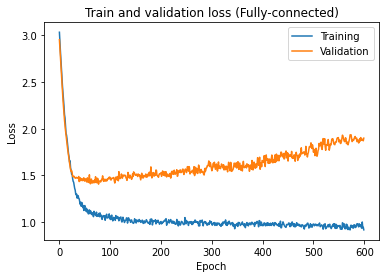

In [24]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and validation loss (Fully-connected)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

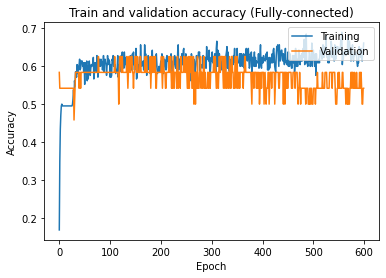

In [25]:
# plot accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Train and validation accuracy (Fully-connected)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

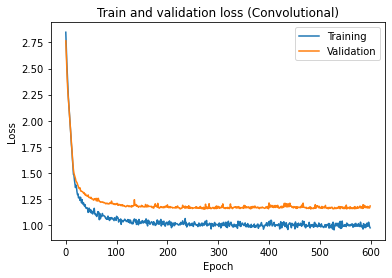

In [26]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Train and validation loss (Convolutional)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

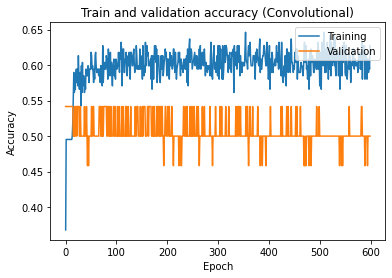

In [27]:
# plot accuracy
plt.plot(history_conv.history['categorical_accuracy'])
plt.plot(history_conv.history['val_categorical_accuracy'])
plt.title('Train and validation accuracy (Convolutional)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [28]:
# load best autoencoder
best_autoencoder = load_model(checkpoint_best_path)
best_conv_autoencoder = load_model(checkpoint_best_conv_path)

In [30]:
# test the performance of the autoencoder
print('Fully-connected')
print('Best model')
results = best_autoencoder.evaluate(inputs_test,Y_test)
predictions = best_autoencoder.predict(inputs_test)

print('Convolutional')
print('Best model')
results = best_conv_autoencoder.evaluate(inputs_test,Y_test)
predictions = best_conv_autoencoder.predict(inputs_test)

Fully-connected
Best model
60/60 [==============================] - 0s 127us/sample - loss: 1.0529 - categorical_accuracy: 0.6833
Convolutional
Best model
60/60 [==============================] - 0s 79us/sample - loss: 2.7462 - categorical_accuracy: 0.6833
